   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>

  * Distributed under the terms of the GPL License
  * Maintainer: carueda@mbari.org
  * Authors: Carlos Rueda carueda@mbari.org, John Ryan ryjo@mbari.org

## Applying the Google Humpback Whale Model on Pacific Ocean Sound data

This notebook exercises the *Humpback whales acoustic detector (by NOAA & Google)* [1] on *Pacific Ocean Sound* [2] data.  Although the model was developed using recordings from breeding habitat of the central and western North Pacific, it proves to be effective when applied to recordings from foraging habitat of the California Current System.

For a 30-minute segment of audio in a given year-month-day,
we apply the model and plot a spectrogram of the corresponding signal along with the song presence scores obtained by the model.

## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!apt-get update -y && apt-get install -y libsndfile1
!pip install boto3 --quiet
!pip install tensorflow==2.4.1 --quiet
!pip install soundfile --quiet
!pip install tensorflow_hub --quiet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [80.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,545 kB]
Hit:14 http://ppa.launchpa

### Import all packages

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from matplotlib import gridspec
import scipy
from six.moves.urllib.request import urlopen
import io
import soundfile as sf

## Supporting code - plotting

### Spectrogram

In [3]:
def plot_spectrogram_scipy(signal, sample_rate, 
                           hydrophone_sensitivity,
                           title=None,
                           with_colorbar=True
                           ):

    # Compute spectrogram:    
    w = scipy.signal.get_window('hann', sample_rate)
    f, t, psd = scipy.signal.spectrogram(signal, 
                                         sample_rate, 
                                         nperseg=sample_rate, 
                                         noverlap=0,
                                         window=w,
                                         nfft=sample_rate,
                                         )
    psd = 10*np.log10(psd) - hydrophone_sensitivity

    # Plot spectrogram:
    plt.imshow(psd, aspect='auto', origin='lower',
               vmin=30, vmax=90,
               cmap='Blues',
               )
    plt.yscale('log')
    y_max = sample_rate / 2
    plt.ylim(10, y_max)

    if with_colorbar:
        plt.colorbar()

    plt.xlabel('Seconds')
    plt.ylabel('Frequency (Hz)')
    plt.title(title or \
              f'Calibrated spectrum levels, 16 {sample_rate / 1000.0} kHz data')


### Scores

In [4]:
def plot_scores(scores, 
                with_steps=False,
                with_dots=True,
                med_filt_size=None,
                ):

    if with_steps:
        # repeat last value to also see a step at the end:
        scores = np.concatenate((scores, scores[-1:]))
        x = range(len(scores))
        plt.step(x, scores, where='post')
    else:
        x = range(len(scores))

    if with_dots:
        plt.plot(x, scores, 'o', color='lightgrey', markersize=9)

    plt.grid(axis='x', color='0.95')
    plt.xlim(xmin=0, xmax=len(scores) - 1)
    plt.ylabel('Model Score')
    plt.xlabel('Seconds')

    if med_filt_size is not None:
        scores_int = [int(s*1000) for s in scores]
        meds_int = scipy.signal.medfilt(scores_int, kernel_size=med_filt_size)
        meds = [m/1000. for m in meds_int]
        plt.plot(x, meds, 'p', color='black', markersize=9)


### Combined spectrogram and scores

In [5]:
def plot_results(scores,
                 context_step_samples,
                 signal,
                 sample_rate,
                 hydrophone_sensitivity,
                 title,
                 scores_with_dots=True,
                 scores_with_steps=False,
                 scores_med_filt_size=None,
                 ):

    signal_len_per_scores = len(scores) * context_step_samples 

    # Note, the nominal signal length per the obtained score array from the
    # model may be larger than the signal given as input.
    # When this happens, we discard as many trailing scores as necesary:
    while signal_len_per_scores > len(signal):
        scores = scores[:-1]
        signal_len_per_scores = len(scores) * context_step_samples
        # print(f':: adjusting: signal_len_per_scores = {signal_len_per_scores}')

    # A final adjustment to make scores and signal "aligned:"
    signal = signal[:signal_len_per_scores]

    # As numpy array:
    signal = np.array(signal)

    fig = plt.figure(figsize=(24, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

    # Plot spectrogram:
    plt.subplot(gs[0])
    plot_spectrogram_scipy(signal, sample_rate, hydrophone_sensitivity,
                           title,
                           with_colorbar=False,
                           )

    # Plot scores:
    fig.add_subplot(gs[1])
    plot_scores(scores, 
                with_dots=scores_with_dots,
                with_steps=scores_with_steps,
                med_filt_size=scores_med_filt_size,
                )

    plt.tight_layout()
    plt.show()

## Loading the model


In [6]:
# Load the model and get its score_fn for use in the exercise:
MODEL_URL = 'https://tfhub.dev/google/humpback_whale/1'
print(f'== Loading model {MODEL_URL} ...')
model = hub.load(MODEL_URL)
print('model:', model)

score_fn = model.signatures['score']

metadata_fn = model.signatures['metadata']
metadata = metadata_fn()
print('metadata:')
for k, v in metadata.items():
    print(f'  {k}: {v}')


== Loading model https://tfhub.dev/google/humpback_whale/1 ...
model: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fe30fd48a50>
metadata:
  input_sample_rate: 10000
  class_names: [b'Mn']
  context_width_samples: 39124


## Exercise: A 30-minute segment with a 1-sec score resolution


### Preparations

In [7]:
# We will get audio from the 16kHz Pacific Sound data
sample_rate = 16_000

# The particular segment will be from the file corresponding to this day:
year, month, day = 2016, 12, 21

# starting at 00h:25m:
at_hour, at_minute = 0, 25 

# and with a 30-min duration:
hours, minutes = 0, 30

# The url to download for that day is:
filename = f'MARS-{year}{month:02}{day:02}T000000Z-16kHz.wav'
url = f'https://pacific-sound-16khz.s3.amazonaws.com/{year}/{month:02}/{filename}'

In [8]:
# Note: instead of downloading the whole day file, in this notebook we will
# only download enough data to cover the desired 30-min segment indicated above
# (including some space for the header of the file).
# The number of bytes to read is captured in max_file_size_dl as follows:
tot_audio_minutes = (at_hour + hours) * 60 + at_minute + minutes
tot_audio_seconds = 60 * tot_audio_minutes
tot_audio_samples = sample_rate * tot_audio_seconds
tot_audio_bytes = 3 * tot_audio_samples    # 3 because audio is 24-bit
max_file_size_dl = 1024 + tot_audio_bytes  # 1024 enough to cover file header

# Let's now load the audio:
print(f'\n==> Loading segment from {year}-{month}-{day} @ {at_hour}h:{at_minute}m with duration {hours}h:{minutes}m')
psound, _ = sf.read(io.BytesIO(urlopen(url).read(max_file_size_dl)), dtype='float32')
# (sf.read also returns the sample rate but we already know it is 16_000)

# Get psound_segment from psound based on offset determined by at_hour:at_minute:
offset_seconds = (at_hour * 60 + at_minute) * 60
offset_samples = sample_rate * offset_seconds
psound_segment = psound[offset_samples:]

print(f'len(psound)         = {len(psound)}')
print(f'len(psound_segment) = {len(psound_segment)}')

# The size of psound_segment in seconds as desired is:
psound_segment_seconds = (hours * 60 + minutes) * 60

print(f'psound_segment_seconds = {psound_segment_seconds}')

# So, we have our desired segment from the 16 kHz file.


==> Loading segment from 2016-12-21 @ 0h:25m with duration 0h:30m
len(psound)         = 52800230
len(psound_segment) = 28800230
psound_segment_seconds = 1800


### Resampling

In [9]:
# Now, resample our 16 kHz segment as the model expects 10 kHz audio:
print(f'==> Resampling to 10 kHz...')
psound_segment_at_10k = librosa.resample(
            psound_segment, 
            orig_sr=sample_rate,
            target_sr=10_000,
            scale=True  # "Scale the resampled signal so that y and y_hat have approximately equal total energy"
            )

# At 10 kHz, this is the nominal size in samples of our desired segment
# when resampled:
psound_segment_samples_at_10k = 10_000 * psound_segment_seconds
print(f'psound_segment_samples_at_10k = {psound_segment_samples_at_10k}')

# Note that psound_segment_at_10k could be a bit larger.
# Do the adjustment so it is our desired segment duration:
psound_segment_at_10k = psound_segment_at_10k[:psound_segment_samples_at_10k]


==> Resampling to 10 kHz...
psound_segment_samples_at_10k = 18000000


### Applying the model

In [10]:
# Now, we apply the model on our segment at 10 kHz:

# We specify a 1-sec score resolution:
context_step_samples = tf.cast(10_000, tf.int64)

print(f'\n==> Applying model ...')
print(f'   len(psound_segment_at_10k) = {len(psound_segment_at_10k)}')

waveform1 = np.expand_dims(psound_segment_at_10k, axis=1)
waveform_exp = tf.expand_dims(waveform1, 0)  # makes a batch of size 1

psound_scores = score_fn(waveform=waveform_exp, 
                         context_step_samples=context_step_samples
                        )
score_values = psound_scores['scores'].numpy()[0]
print(f'==> Model applied.  Obtained score_values = {len(score_values)}')


==> Applying model ...
   len(psound_segment_at_10k) = 18000000
==> Model applied.  Obtained score_values = 1815


### Plotting the results


==> Plotting results


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


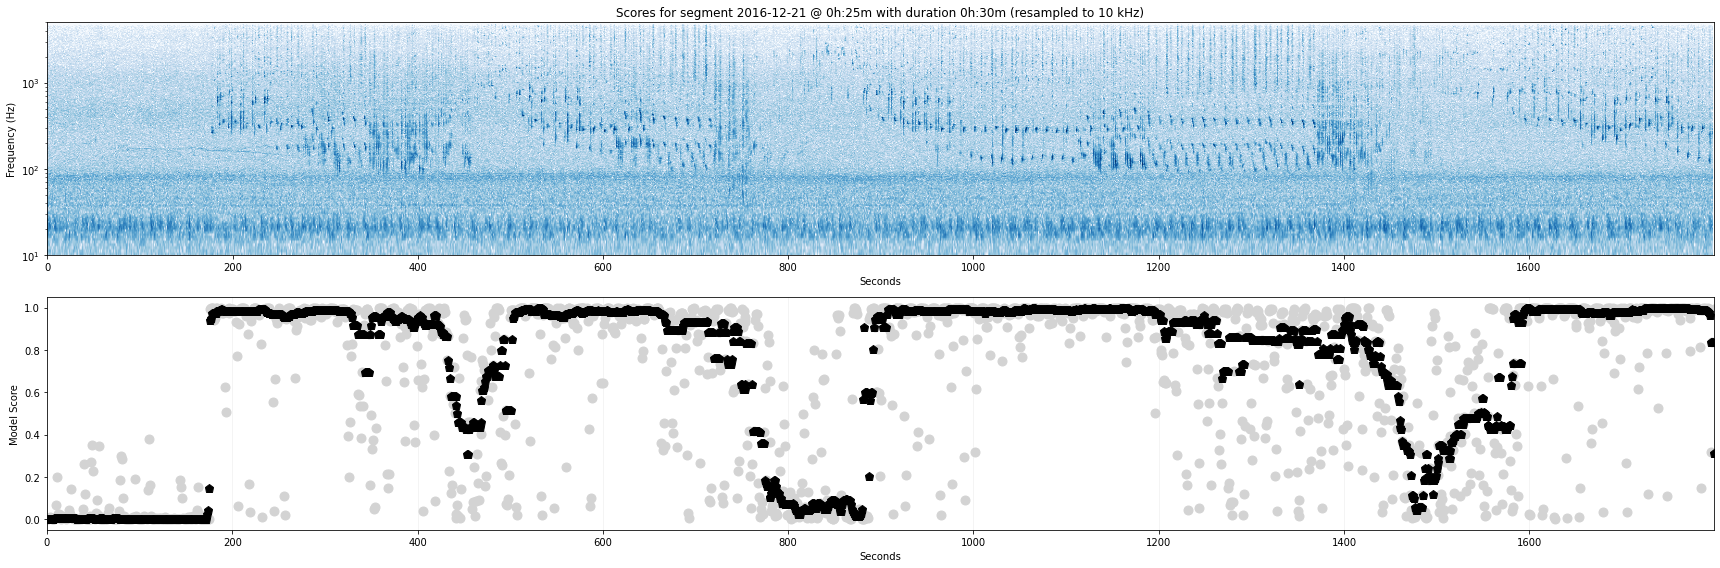

In [11]:
# Let's see the results, with a plot of the spectrogram along with
# the 1-sec resolution score and a median filtered score:

print(f'\n==> Plotting results')

title = f'Scores for segment {year}-{month}-{day}'
title += f' @ {at_hour}h:{at_minute}m with duration {hours}h:{minutes}m'
title += ' (resampled to 10 kHz)'

plot_results(score_values,
             context_step_samples,
             signal=psound_segment_at_10k,
             sample_rate=10_000,
             hydrophone_sensitivity=-168.8,
             title=title,
             scores_with_dots=True,
             scores_med_filt_size=25,
            )

## References

- [1] https://tfhub.dev/google/humpback_whale/1
- [2] https://doi.org/10.1109/OCEANS.2016.7761363